### Libraries Initialization

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import math
        
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

### N CLASS [Abstract class]

In [75]:
class N:
    def __init__(self, PATH):
        #Receive path from subclass
        self.PATH = PATH
        #If path does not exist, create new folder
        if not os.path.exists(PATH):
            os.makedirs(PATH)
        #Create checkpoint callback
        self.CHECKPOINT = tf.keras.callbacks.ModelCheckpoint(PATH + '/MODEL_WEIGHTS.ckpt',save_weights_only=True,verbose=1)
        #Create model
        self.MODEL = Sequential()

    def FIT(self, TR_X, TR_Y, EPOCHS, BATCH_SIZE):
        self.MODEL.fit(TR_X, TR_Y, epochs = EPOCHS, batch_size = BATCH_SIZE, callbacks=[self.CHECKPOINT])

    def LOAD(self, PATH = None):
        if(PATH == None):
            self.MODEL.load_weights(self.PATH + '/MODEL_WEIGHTS.ckpt')
        else:
            self.MODEL.load_weights(PATH + '/MODEL_WEIGHTS.ckpt')

### LSTM Class

In [89]:
class LSTM_MODEL(N):
    #IF USE AUTO MODE, PLEASE MAKE SURE THAT DATA IS IN THE SAME FOLDER AS THIS FILE
    def __init__(self, PATH = 'LSTM_MODEL_SAVE', AUTO_DEFINE = True):
        if not os.path.exists(PATH):
            super().__init__(PATH)
            if AUTO_DEFINE:
                try:
                    RAW_DATA = pd.read_csv('DATA.csv')
                except FileNotFoundError:
                    #print("DATA.csv NOT FOUND [ERROR]")
                else:
                    #print("DATA.csv LOAD SUCCESSFULLY [AUTO-GENERATE NEW MODEL]")
                    self.INITIALIZE(NUM_PREDICTORS = RAW_DATA.shape[1])
            print("CALL INITIAL() TO DECLARE MODEL PARAMETERS [EMPTY MODEL GENERATED]")
        else:
            self.PATH = PATH
            super().__init__(PATH)
            self.LOAD()

#INITIALIZE FUNCTIONs
    #[AIO]
    def INITIALIZE(self , TR_FILE = 'DATA.csv', TR_DATA = [], NUM_PREDICTORS = 1, TIME_STEP = 64, NUM_LAYERS = 2, NUM_NEURONS_PER_LAYER = 64, DROP_OUT_RATE = 0.2):
        if len(TR_DATA) != 0:
            self.INITIALIZE_TRAINING_SET_BY_DATA(TR_DATA = TR_DATA, NUM_PREDICTORS = NUM_PREDICTORS, TIME_STEP = TIME_STEP)
        else:
            self.INITIALIZE_TRAINING_SET_BY_FILE(TR_FILE = TR_FILE, NUM_PREDICTORS = NUM_PREDICTORS, TIME_STEP = TIME_STEP)
        self.INITIALIZE_MODEL(NUM_LAYERS = 4, NUM_NEURONS_PER_LAYER = 64, DROP_OUT_RATE = 0.2)

    #IN ORDER TO INITITALIZE STRUCTURE, MUST INITIALIZE TRAINING SET FIRST
    def INITIALIZE_TRAINING_SET_BY_FILE(self, TR_FILE = 'DATA.csv', NUM_PREDICTORS = 1, TIME_STEP = 64):
        self.NUM_PREDICTORS = NUM_PREDICTORS
        self.TIME_STEP = TIME_STEP
    
        TRAINING_RAW_DATA = pd.read_csv(TR_FILE)
        self.TRAINING_DATA = TRAINING_RAW_DATA.iloc[:,0:NUM_PREDICTORS].values
        
        #Fill nan data with previous data
        RAW_DATAFRAME = pd.DataFrame(self.TRAINING_DATA)
        FILLED_DATA = RAW_DATAFRAME.dropna(how='all')
        FILLED_DATA = FILLED_DATA.fillna(method='bfill')
        self.TRAINING_DATA = FILLED_DATA.values

        #SAVE TRAINING DATA TO LOCAL FILE
        columns = []
        for c in range(NUM_PREDICTORS):
            columns.append('COLUMN' + str(c))
            
        np.savetxt(self.PATH + '/TRAINING_DATA.csv', self.TRAINING_DATA, delimiter=',', header=','.join(columns))
        
        TRAINING_DATA_SCALED = np.empty(self.TRAINING_DATA.shape)
        self.SCALER = []
        for S in range(self.NUM_PREDICTORS):
            scaler = MinMaxScaler(feature_range = (0, 1))
            TRAINING_DATA_SCALED[:,S:S+1] = scaler.fit_transform(self.TRAINING_DATA[:,S:S+1])
            self.SCALER.append(scaler)
        
        self.TR_X = np.empty([len(self.TRAINING_DATA)-TIME_STEP, TIME_STEP, NUM_PREDICTORS])
        self.TR_Y = []

        for D in range(NUM_PREDICTORS):
            for index in range(TIME_STEP, len(self.TRAINING_DATA)):
                    LIST = TRAINING_DATA_SCALED[index-TIME_STEP:index, D]
                    for V in range(len(LIST)):
                        self.TR_X[index-TIME_STEP,V,D] = LIST[V]
                        
        for index in range(TIME_STEP, len(self.TRAINING_DATA)):
            self.TR_Y.append(TRAINING_DATA_SCALED[index, 0])
    
        self.TR_X, self.TR_Y = np.array(self.TR_X), np.array(self.TR_Y)
        self.TR_X = np.reshape(self.TR_X, (self.TR_X.shape[0], self.TR_X.shape[1], NUM_PREDICTORS))
        
    #IN ORDER TO INITITALIZE STRUCTURE, MUST INITIALIZE TRAINING SET FIRST
    def INITIALIZE_TRAINING_SET_BY_DATA(self, TR_DATA, NUM_PREDICTORS = 1, TIME_STEP = 64):
        self.TRAINING_DATA = TR_DATA
        self.NUM_PREDICTORS = NUM_PREDICTORS
        self.TIME_STEP = TIME_STEP
        
        #Fill nan data with previous data
        RAW_DATAFRAME = pd.DataFrame(self.TRAINING_DATA)
        FILLED_DATA = RAW_DATAFRAME.dropna(how='all')
        FILLED_DATA = FILLED_DATA.fillna(method='bfill')
        self.TRAINING_DATA = FILLED_DATA.values
        
        #SAVE TRAINING DATA TO LOCAL FILE
        columns = []
        for c in range(NUM_PREDICTORS):
            columns.append('COLUMN' + str(c))
            
        np.savetxt(self.PATH + '/TRAINING_DATA.csv', self.TRAINING_DATA, delimiter=',', header=','.join(columns))
        
        TRAINING_DATA_SCALED = np.empty(self.TRAINING_DATA.shape)
        self.SCALER = []
        for S in range(self.NUM_PREDICTORS):
            scaler = MinMaxScaler(feature_range = (0, 1))
            TRAINING_DATA_SCALED[:,S:S+1] = scaler.fit_transform(self.TRAINING_DATA[:,S:S+1])
            self.SCALER.append(scaler)
        
        self.TR_X = np.empty([len(self.TRAINING_DATA)-TIME_STEP, TIME_STEP, NUM_PREDICTORS])
        self.TR_Y = []

        for D in range(NUM_PREDICTORS):
            for index in range(TIME_STEP, len(self.TRAINING_DATA)):
                    LIST = TRAINING_DATA_SCALED[index-TIME_STEP:index, D]
                    for V in range(len(LIST)):
                        self.TR_X[index-TIME_STEP,V,D] = LIST[V]
                        
        for index in range(TIME_STEP, len(self.TRAINING_DATA)):
            self.TR_Y.append(TRAINING_DATA_SCALED[index, 0])
    
        self.TR_X, self.TR_Y = np.array(self.TR_X), np.array(self.TR_Y)
        self.TR_X = np.reshape(self.TR_X, (self.TR_X.shape[0], self.TR_X.shape[1], NUM_PREDICTORS))

    #IN ORDER TO FIT THE MODEL MUST INITITALIZE MODEL STRUCTURE
    def INITIALIZE_MODEL(self, NUM_LAYERS = 4, NUM_NEURONS_PER_LAYER = 64, DROP_OUT_RATE = 0.2):
        self.NUM_LAYERS = NUM_LAYERS
        self.NUM_NEURONS_PER_LAYER = NUM_NEURONS_PER_LAYER
        self.DROP_OUT_RATE = DROP_OUT_RATE
        
        self.INPUT_SHAPE_X = self.TR_X.shape[1]
        self.INPUT_SHAPE_Y = self.NUM_PREDICTORS
        
        self.MODEL = Sequential()
        self.MODEL.add(LSTM(units = NUM_NEURONS_PER_LAYER, return_sequences = True, input_shape = (self.INPUT_SHAPE_X, self.INPUT_SHAPE_Y)))
        self.MODEL.add(Dropout(DROP_OUT_RATE))
        
        for L in range(NUM_LAYERS-2):
            self.MODEL.add(LSTM(units = NUM_NEURONS_PER_LAYER, return_sequences = True))
            self.MODEL.add(Dropout(DROP_OUT_RATE))
            
        self.MODEL.add(LSTM(units = NUM_NEURONS_PER_LAYER, return_sequences = False))
        self.MODEL.add(Dropout(DROP_OUT_RATE))
        
        self.MODEL.add(Dense(units = 1))
        
        self.MODEL.compile(optimizer = 'Adam', loss = 'mean_squared_error')

#FIT FUNCTIONs
    #SAVE THE MODEL WEIGHT EVERY EPOCH, SAVE THE MODEL VARIABLES AT THE END WHILE FITING
    def FIT(self, EPOCHS = 4, BATCH_SIZE = 32, PRINT_FIT_PLOT = False):
        super().FIT(self.TR_X, self.TR_Y, EPOCHS, BATCH_SIZE)
        SAVE_VARIBLE = open(self.PATH + '/MODEL_VARIABLES.txt', "w")
        
        SAVE_VARIBLE.write(str(self.NUM_LAYERS) + "/" + str(self.NUM_NEURONS_PER_LAYER) + "/" + str(self.DROP_OUT_RATE) + "/" + str(self.NUM_PREDICTORS) + "/" + str(self.TIME_STEP))
        SAVE_VARIBLE.close()
        
        if(PRINT_FIT_PLOT):
            self.PREDICT_OVER_TRAINING_SET(PRIINT_COMPARE_PLOT = True)

#PREDICTION FUNCTIONs
    #PREDICT N AFTERWARD DATAs BASE ON TRAINING DATA
    def PREDICT_TRAINING_EXTENDED(self, LENGTH, PRINT_EXTENDED_PLOT = False):
        PREDICTIONS = []
        TRAINING_DATA_SCALED = np.empty(self.TRAINING_DATA.shape)

        for S in range(self.NUM_PREDICTORS):
            TRAINING_DATA_SCALED[:,S:S+1] = self.SCALER[S].fit_transform(self.TRAINING_DATA[:,S:S+1])
        
        for index in range(LENGTH):
            
            TE_X = []
            TE_X.append(TRAINING_DATA_SCALED[len(TRAINING_DATA_SCALED)-self.TIME_STEP:,0:self.NUM_PREDICTORS])
        
            TE_X = np.array(TE_X)
            TE_X = np.reshape(TE_X, (TE_X.shape[0], TE_X.shape[1], self.NUM_PREDICTORS))

            PREDICTION = self.MODEL.predict(TE_X)
            
            APPEND_RESULT = np.empty((1,self.NUM_PREDICTORS))
            
            for i in range(self.NUM_PREDICTORS):
                APPEND_RESULT[0][i] = PREDICTION

            TRAINING_DATA_SCALED = np.concatenate((TRAINING_DATA_SCALED, APPEND_RESULT))
            
            PREDICTION = self.SCALER[0].inverse_transform(PREDICTION)
            
            PREDICTIONS.append(PREDICTION[0][0])
            
        if(PRINT_EXTENDED_PLOT):
    
            X = np.arange(self.TRAINING_DATA.shape[0] - 1, self.TRAINING_DATA.shape[0] + LENGTH)
            Y = np.array(PREDICTIONS).reshape(-1, 1)
            Y = np.insert(Y, 0, self.TRAINING_DATA[self.TRAINING_DATA.shape[0]-1:self.TRAINING_DATA.shape[0],0:1])
            plt.plot(X, Y, color = '#ba2727', label = 'PREDICTIONS')
            plt.plot(self.TRAINING_DATA[:,0:1], color = '#adadad', label = 'PREVIOUS DATA')
            plt.legend()
            plt.show()
            
        return PREDICTIONS

    #REDRAW THE TRAINING SET TREND BY CURRENT FITTED MODEL
    def PREDICT_OVER_TRAINING_SET(self, PRIINT_COMPARE_PLOT = False):
        TRAINING_DATA_SCALED = np.empty(self.TRAINING_DATA.shape)

        for S in range(self.NUM_PREDICTORS):
            TRAINING_DATA_SCALED[:,S:S+1] = self.SCALER[S].fit_transform(self.TRAINING_DATA[:,S:S+1])
        
        PREDICTIONS = np.empty(self.TRAINING_DATA.shape)
        
        TE_X = np.empty([len(self.TRAINING_DATA)-self.TIME_STEP, self.TIME_STEP, self.NUM_PREDICTORS])

        for D in range(self.NUM_PREDICTORS):
            for index in range(self.TIME_STEP, len(self.TRAINING_DATA)):
                    LIST = TRAINING_DATA_SCALED[index-self.TIME_STEP:index, D]
                    for V in range(len(LIST)):
                        TE_X[index-self.TIME_STEP,V,D] = LIST[V]
            
        PREDICTIONS = self.MODEL.predict(TE_X)
            
        PREDICTIONS = self.SCALER[0].inverse_transform(PREDICTIONS)
            
        if(PRIINT_COMPARE_PLOT):
            
            plt.plot(self.TRAINING_DATA[self.TIME_STEP:,0:1], color = '#adadad', label = 'TRAINING_SET')
            plt.plot(PREDICTIONS, color = '#ba2727', label = 'PREDICTIONS')
            plt.legend()
            plt.show()
            
        return PREDICTIONS
    
    #DRAW THE FORWARD TREND COMPARE WITH VALIDATION SET
    def PREDICT_COMPARE_VALIDATION(self, LENGTH):  
        PREDICTIONS = []
        TRAINING_DATA_SCALED = np.empty(self.TRAINING_DATA.shape)

        for S in range(self.NUM_PREDICTORS):
            TRAINING_DATA_SCALED[:,S:S+1] = self.SCALER[S].fit_transform(self.TRAINING_DATA[:,S:S+1])
        
        for index in range(LENGTH):
            
            TE_X = []
            TE_X.append(TRAINING_DATA_SCALED[len(TRAINING_DATA_SCALED)-self.TIME_STEP:,0:self.NUM_PREDICTORS])
        
            TE_X = np.array(TE_X)
            TE_X = np.reshape(TE_X, (TE_X.shape[0], TE_X.shape[1], self.NUM_PREDICTORS))

            PREDICTION = self.MODEL.predict(TE_X)
            
            APPEND_RESULT = np.empty((1,self.NUM_PREDICTORS))
            
            for i in range(self.NUM_PREDICTORS):
                APPEND_RESULT[0][i] = PREDICTION

            TRAINING_DATA_SCALED = np.concatenate((TRAINING_DATA_SCALED, APPEND_RESULT))
            
            PREDICTION = self.SCALER[0].inverse_transform(PREDICTION)
            
            PREDICTIONS.append(PREDICTION[0][0])
            

        EXTEND_DATA = self.SCALER[0].inverse_transform(TRAINING_DATA_SCALED[self.TRAINING_DATA.shape[0]:,0:1])
        
        REAL_DATA = pd.read_csv("VALIDATION.csv")
        plt.plot(REAL_DATA.iloc[:,0:1].values, color = 'gray', label = 'VALIDATION_SET')
        plt.plot(EXTEND_DATA, color = 'blue', label = 'PREDICTIONS')
        plt.legend()
        plt.show()
            
        return PREDICTIONS

    #DRAW THE FORWARD TREND COMPARE WITH NEW DATA
    def PREDICT_ON_NEW_DATA(self, LENGTH, NEW_DATA, PRINT_EXTENDED_PLOT = False):
        PREDICTIONS = []
        TRAINING_DATA_SCALED = np.empty(NEW_DATA.shape)

        for S in range(self.NUM_PREDICTORS):
            TRAINING_DATA_SCALED[:,S:S+1] = self.SCALER[S].fit_transform(NEW_DATA[:,S:S+1])
        
        for index in range(LENGTH):
            
            TE_X = []
            TE_X.append(TRAINING_DATA_SCALED[len(TRAINING_DATA_SCALED)-self.TIME_STEP:,0:self.NUM_PREDICTORS])
        
            TE_X = np.array(TE_X)
            TE_X = np.reshape(TE_X, (TE_X.shape[0], TE_X.shape[1], self.NUM_PREDICTORS))

            PREDICTION = self.MODEL.predict(TE_X)
            
            APPEND_RESULT = np.empty((1,self.NUM_PREDICTORS))
            
            for i in range(self.NUM_PREDICTORS):
                APPEND_RESULT[0][i] = PREDICTION

            TRAINING_DATA_SCALED = np.concatenate((TRAINING_DATA_SCALED, APPEND_RESULT))
            
            PREDICTION = self.SCALER[0].inverse_transform(PREDICTION)
            
            PREDICTIONS.append(PREDICTION[0][0])
            
        if(PRINT_EXTENDED_PLOT):
            EXTEND_DATA = self.SCALER[0].inverse_transform(TRAINING_DATA_SCALED[:,0:1])

            plt.plot(EXTEND_DATA, color = 'blue', label = 'PREDICTIONS')
            plt.legend()
            plt.show()
            
        return PREDICTIONS
        
#SUPPORT FUNCTIONs
    #LOAD SAVED PRE-TRAINED MODEL [AUTOMATICALLY CALLED WHEN INITIALIZE EXISTING MODEL]
    def LOAD(self):
        try:    
            SAVE_VARIBLE = open(self.PATH + '/MODEL_VARIABLES.txt', 'r')
        except FileNotFoundError:
            #print("MODEL NOT FOUND [AUTO-GENERATE NEW MODEL]")
            RAW_DATA = pd.read_csv('DATA.csv')
            self.INITIALIZE(NUM_PREDICTORS = RAW_DATA.shape[1])
        else:
            #print("SAVED RECORD FOUND [RELOAD SAVED MODEL]")
            VARIABLES = SAVE_VARIBLE.read()
            VARIABLES = VARIABLES.split("/")
            
            #Load training data
            TRAINING_RAW_DATA = pd.read_csv(self.PATH + '/TRAINING_DATA.csv')
            TRAINING_DATA = TRAINING_RAW_DATA.iloc[:,0:int(VARIABLES[3])].values
            
            #Fill nan data with previous data
            RAW_DATAFRAME = pd.DataFrame(TRAINING_DATA)
            FILLED_DATA = RAW_DATAFRAME.dropna(how='all')
            FILLED_DATA = FILLED_DATA.fillna(method='bfill')
            TRAINING_DATA = FILLED_DATA.values
            
            self.INITIALIZE_TRAINING_SET_BY_DATA(TRAINING_DATA, int(VARIABLES[3]), int(VARIABLES[4]))
            self.INITIALIZE_MODEL(int(VARIABLES[0]), int(VARIABLES[1]), float(VARIABLES[2]))
            super().LOAD(self.PATH)

### Multi Predictors LSTM

In [90]:
class MP_LSTM():
    def __init__(self, PATH = 'MULTI_PREDICTORS_LSTM_MODEL', NUM_PREDICTORS = 1, TR_FILE = 'DATA.csv', TR_DATA = []):
        #Create folder to save models
        self.PATH = PATH
        if not os.path.exists(PATH):
            os.makedirs(PATH)
        
        self.NUM_PREDICTORS = NUM_PREDICTORS
        self.LSTM_MODELs = []
        
        #Initialize original training data
        if len(TR_DATA) != 0:
            #Fill nan data with previous data
            RAW_DATAFRAME = pd.DataFrame(TR_DATA)
            FILLED_DATA = RAW_DATAFRAME.dropna(how='all')
            FILLED_DATA = FILLED_DATA.fillna(method='bfill')
            self.ORIGINAL_TRAINING_DATA = FILLED_DATA.values
        else:
            TR_DATA = pd.read_csv('DATA.csv')
            TR_DATA = TR_DATA.iloc[:,0:NUM_PREDICTORS].values
            RAW_DATAFRAME = pd.DataFrame(TR_DATA)
            FILLED_DATA = RAW_DATAFRAME.dropna(how='all')
            FILLED_DATA = FILLED_DATA.fillna(method='bfill')
            self.ORIGINAL_TRAINING_DATA = FILLED_DATA.values
        
        #Initialize sub-models
        for i in range(NUM_PREDICTORS):
            lstm_model = LSTM_MODEL(PATH = self.PATH + '/SUB_MODEL_' + str(i))
            if len(TR_DATA) != 0:
                TR_DATA[:,[0,i]] = TR_DATA[:,[i,0]]
                lstm_model.INITIALIZE(TR_DATA = self.ORIGINAL_TRAINING_DATA, NUM_PREDICTORS = NUM_PREDICTORS)
            else:
                TR_DATA = pd.read_csv('DATA.csv')
                TR_DATA = TR_DATA.iloc[:,0:NUM_PREDICTORS].values
                TR_DATA[:,[0,i]] = TR_DATA[:,[i,0]]
                lstm_model.INITIALIZE(TR_DATA = self.ORIGINAL_TRAINING_DATA, NUM_PREDICTORS = NUM_PREDICTORS)
                
            self.LSTM_MODELs.append(lstm_model)
            
    def FIT(self, EPOCHS = 4, BATCH_SIZE = 32, PRINT_FIT_PLOT = False):
        for i in range(self.NUM_PREDICTORS):
            self.LSTM_MODELs[i].FIT(EPOCHS, BATCH_SIZE, PRINT_FIT_PLOT)
            
    def PREDICT(self, LENGTH, PRINT_EXTENDED_PLOT = False):
        TE_DATA = self.ORIGINAL_TRAINING_DATA
        ROW = np.empty(self.NUM_PREDICTORS)
        
        for l in range(LENGTH):
            for i in range(self.NUM_PREDICTORS):
                ROW[i] = self.LSTM_MODELs[i].PREDICT_ON_NEW_DATA(1, TE_DATA)[0]
            TE_DATA = np.vstack([TE_DATA, ROW])
            
        if(PRINT_EXTENDED_PLOT):
            X = np.arange(self.ORIGINAL_TRAINING_DATA.shape[0] - 1, self.ORIGINAL_TRAINING_DATA.shape[0] + LENGTH)
            Y = TE_DATA[self.ORIGINAL_TRAINING_DATA.shape[0]:,0:1]
            Y = np.insert(Y, 0, self.ORIGINAL_TRAINING_DATA[self.ORIGINAL_TRAINING_DATA.shape[0]-1:self.ORIGINAL_TRAINING_DATA.shape[0],0:1])
            plt.plot(X, Y, color = '#ba2727', label = 'PREDICTIONS')
            plt.plot(self.ORIGINAL_TRAINING_DATA[:,0:1], color = '#adadad', label = 'PREVIOUS DATA')
            plt.legend()
            plt.show()
        
        return TE_DATA     

### CODE [MP_LSTM]

In [91]:
LSTM_MODEL = MP_LSTM(PATH = 'MODEL2', NUM_PREDICTORS = 3)

DATA.csv LOAD SUCCESSFULLY [AUTO-GENERATE NEW MODEL]
CALL INITIAL() TO DECLARE MODEL PARAMETERS [EMPTY MODEL GENERATED]
DATA.csv LOAD SUCCESSFULLY [AUTO-GENERATE NEW MODEL]
CALL INITIAL() TO DECLARE MODEL PARAMETERS [EMPTY MODEL GENERATED]
DATA.csv LOAD SUCCESSFULLY [AUTO-GENERATE NEW MODEL]
CALL INITIAL() TO DECLARE MODEL PARAMETERS [EMPTY MODEL GENERATED]


Epoch 1/4
30/30 [==============================] - ETA: 0s - loss: 0.0291
Epoch 1: saving model to MODEL2/SUB_MODEL_0\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 4s 22ms/step - loss: 0.0291
Epoch 2/4
29/30 [============================>.] - ETA: 0s - loss: 0.0087
Epoch 2: saving model to MODEL2/SUB_MODEL_0\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 23ms/step - loss: 0.0086
Epoch 3/4
30/30 [==============================] - ETA: 0s - loss: 0.0065
Epoch 3: saving model to MODEL2/SUB_MODEL_0\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 24ms/step - loss: 0.0065
Epoch 4/4
30/30 [==============================] - ETA: 0s - loss: 0.0063
Epoch 4: saving model to MODEL2/SUB_MODEL_0\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 11ms/step


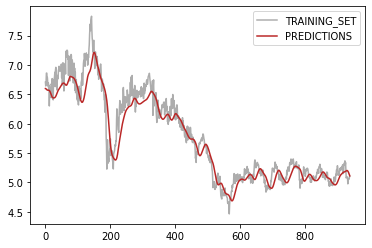

Epoch 1/4
30/30 [==============================] - ETA: 0s - loss: 0.0278
Epoch 1: saving model to MODEL2/SUB_MODEL_1\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 4s 24ms/step - loss: 0.0278
Epoch 2/4
30/30 [==============================] - ETA: 0s - loss: 0.0073
Epoch 2: saving model to MODEL2/SUB_MODEL_1\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 24ms/step - loss: 0.0073
Epoch 3/4
28/30 [===========================>..] - ETA: 0s - loss: 0.0063
Epoch 3: saving model to MODEL2/SUB_MODEL_1\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 25ms/step - loss: 0.0063
Epoch 4/4
29/30 [============================>.] - ETA: 0s - loss: 0.0060
Epoch 4: saving model to MODEL2/SUB_MODEL_1\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 11ms/step


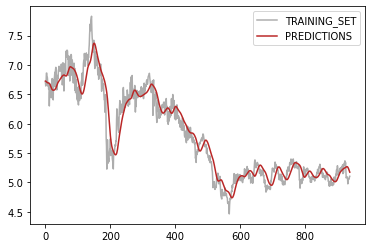

Epoch 1/4
30/30 [==============================] - ETA: 0s - loss: 0.0330
Epoch 1: saving model to MODEL2/SUB_MODEL_2\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 4s 27ms/step - loss: 0.0330
Epoch 2/4
30/30 [==============================] - ETA: 0s - loss: 0.0086
Epoch 2: saving model to MODEL2/SUB_MODEL_2\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 23ms/step - loss: 0.0086
Epoch 3/4
29/30 [============================>.] - ETA: 0s - loss: 0.0063
Epoch 3: saving model to MODEL2/SUB_MODEL_2\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 25ms/step - loss: 0.0063
Epoch 4/4
29/30 [============================>.] - ETA: 0s - loss: 0.0059
Epoch 4: saving model to MODEL2/SUB_MODEL_2\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 11ms/step


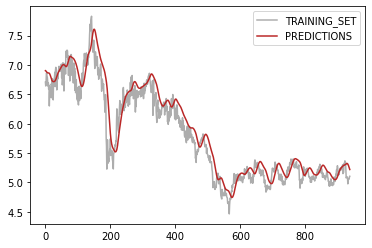

In [92]:
LSTM_MODEL.FIT(PRINT_FIT_PLOT = True)

1/1 [==============================] - 0s 21ms/step


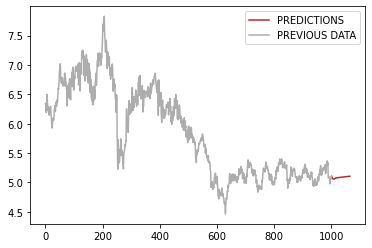

In [93]:
PREDICTIONS = LSTM_MODEL.PREDICT(LENGTH = 64, PRINT_EXTENDED_PLOT = True)

### CODE [LSTM]

In [39]:
lstm_model = LSTM_MODEL()

SAVED RECORD FOUND [RELOAD SAVED MODEL]


30/30 [==============================] - ETA: 0s - loss: 0.0039
Epoch 1: saving model to LSTM_MODEL_SAVE\MODEL_WEIGHTS.ckpt
30/30 [==============================] - 1s 8ms/step


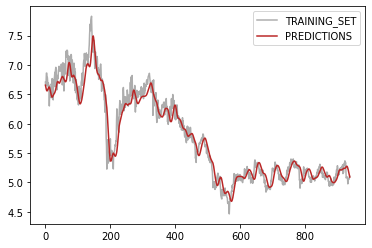

In [40]:
lstm_model.FIT(EPOCHS = 1, BATCH_SIZE = 32, PRINT_FIT_PLOT=True)

1/1 [==============================] - 0s 22ms/step


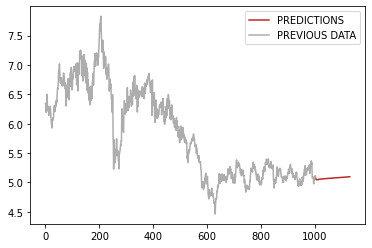

In [38]:
LSTM_PREDICTIONs = lstm_model.PREDICT_TRAINING_EXTENDED(LENGTH=128, PRINT_EXTENDED_PLOT=True)

In [8]:
TR_DATA = pd.read_csv('DATA.csv')
TR_DATA = TR_DATA.iloc[:,0:2].values
TR_DATA[:,[0,1]] = TR_DATA[:,[1,0]]